In [1]:
%reset -f
%matplotlib inline
import numpy as np
import lib.io.stan
import matplotlib.pyplot as plt
import os
from matplotlib import colors, cm, gridspec
import lib.io.stan

Read Gain matrix and fitting target from simulated data

In [20]:
data_dir = 'datasets/id001_ac'
results_dir = 'results/exp10/exp10.6'
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)

network = np.load(f'{data_dir}/AC_network.npz')
SC = network['SC']
SC = SC / np.max(SC)
SC[np.diag_indices(SC.shape[0])] = 0
gain_mat = network['gain_mat']

syn_data = np.load(f'{data_dir}/AC_fit_trgt.npz')

Dump the data to R file and start sampling with HMC

In [ ]:
nn = SC.shape[0]
ns = gain_mat.shape[0]
nt = syn_data['fit_trgt'].shape[0]
epsilon = 0.1
sigma = 0.1

stan_fname = 'vep-snsrfit-lin'
lib.io.stan.create_process(['bash','/home/anirudhnihalani/scripts/stancompile.sh', stan_fname],block=True)

data = {'nn':nn, 'ns':ns, 'nt':nt, 'gain': gain_mat, 'seeg':syn_data['fit_trgt'],
        'epsilon':epsilon, 'sigma':sigma}

input_Rfile = f'fit_data_AC_lin.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/{input_Rfile}',data)

nchains = 1
with open('vep-snsrfit-lin.sh','r') as fd:
    slurm_script = fd.read().format(f'{results_dir}/Rfiles', results_dir, input_Rfile, nchains, epsilon)
with open(f'tmp/vep-snsrfit-lin-eps{epsilon:0.5f}.sh','w') as fd:
    fd.write(slurm_script)
lib.io.stan.create_process(['sbatch',f'tmp/vep-snsrfit-lin-eps{epsilon:0.5f}.sh'],block=False)


Read the samples

In [3]:
csv_fname = 'results/exp10/exp10.6/samples_eps0.10000_chain1.csv'
nwarmup = 500
nsampling = 500
ignore_warmup = False
hmc_samples = lib.io.stan.read_samples(csv_fname,nwarmup,nsampling,ignore_warmup)

Plot the inferred source acitivity of EZ and PZ

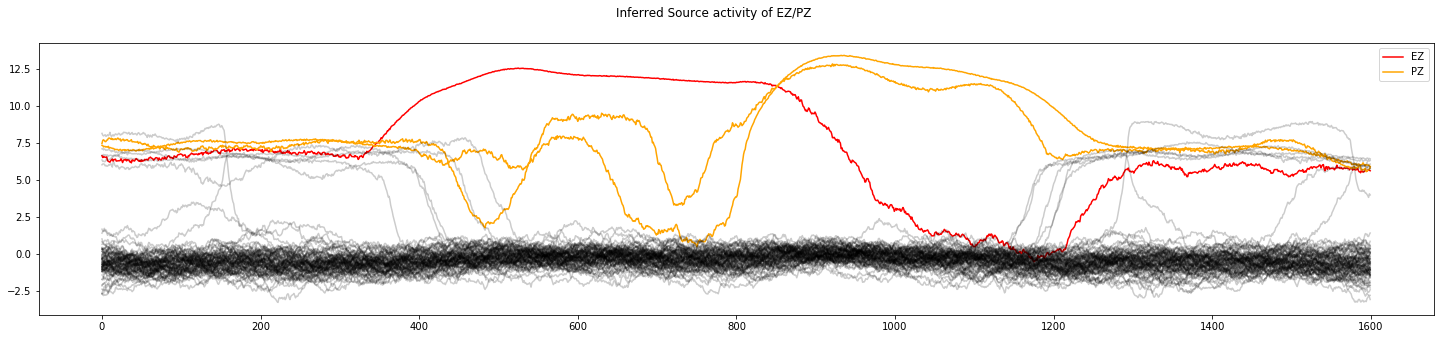

In [18]:
t = hmc_samples['x'][-1,:,:]
nn = t.shape[-1]
plt.figure(figsize=[25,5])
plt.plot(t[:,59], label='EZ', color='red')
plt.plot(t[:,74], label='PZ', color='orange')
plt.plot(t[:,82], color='orange')
plt.suptitle('Inferred Source activity of EZ/PZ')
plt.plot(t[:, np.setxor1d(np.r_[0:nn], np.array([59,82,74]))], color='k', alpha=0.2)
plt.legend()

Posterior predicted seeg

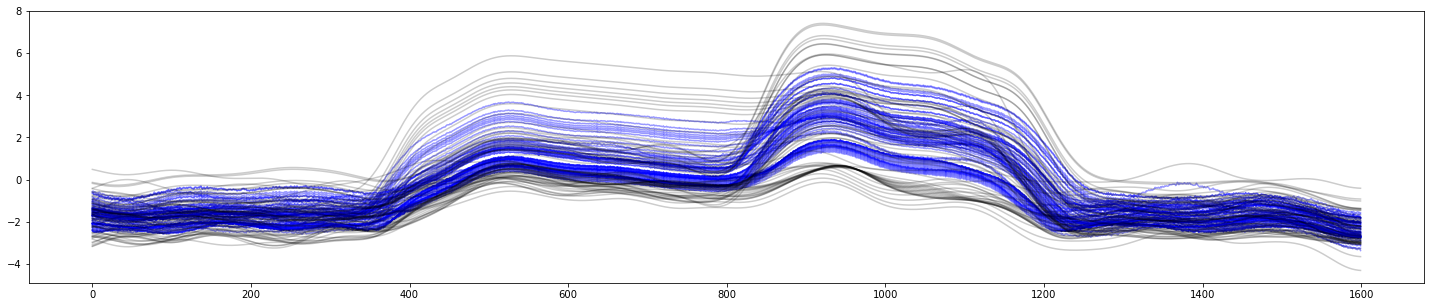

In [24]:
seeg = np.log(gain_mat @ np.exp(hmc_samples['x'][-1,...].T)) + hmc_samples['offset'][-1]
plt.figure(figsize=(25,5))
plt.plot(seeg.T,'b',alpha=0.4);
plt.plot(syn_data['fit_trgt'],'k',alpha=0.2);
